In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pygeohash as pgh
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# source of the data is https://www.kaggle.com/rtatman/188-million-us-wildfires
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")

### How does the distribution of fires look like? Can we see 'hot-spots'?

In [3]:
df = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_YEAR, FIRE_SIZE FROM Fires;", conn)
heat_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df = heat_df[heat_df["FIRE_SIZE"] > 1800] 
heat_df = heat_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df.iterrows()]
del heat_df

In [4]:
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",                    
                    zoom_start = 3) 

# Plot it on the map
HeatMap(heat_data, min_opacity=.4, max_val=.8).add_to(map_)

# Display the map
map_

## Which state(s) is(/are) the most fire prone? 

In [5]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State FROM Fires GROUP BY State;", conn)
df = df.set_index("STATE")
df[:5]

,SUM_FIRE_SIZE
STATE,
AK,3.223309e+07
AL,9.205453e+05
AR,5.089118e+05
AZ,5.576681e+06
CA,1.274586e+07


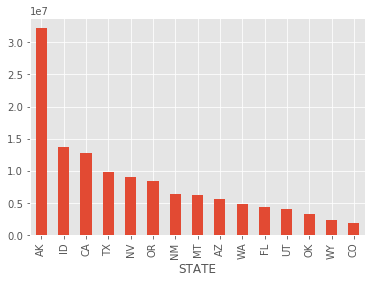

In [6]:
df["SUM_FIRE_SIZE"].sort_values(ascending=False)[:15].plot(kind="bar");

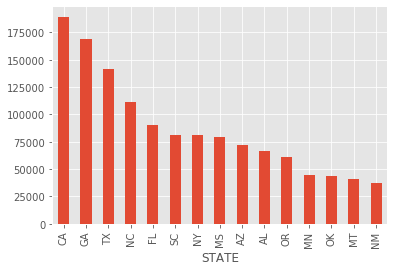

In [7]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, State FROM Fires GROUP BY State;", conn)
df.set_index("STATE")["COUNT_INCIDENTS"].sort_values(ascending=False)[:15].plot(kind="bar");

There are to states: CA has the most incidents, while AK leads significant in terms of fire size.

## Can we identify an evolution / trend?

In [8]:
df = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_YEAR, FIRE_SIZE FROM Fires;", conn)
heat_time_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
heat_time_df = heat_time_df[heat_time_df["FIRE_SIZE"] > 1500]
heat_time_df = heat_time_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_time_data = [
    [
        [row['LATITUDE'],row['LONGITUDE']] for index, row in heat_time_df[heat_time_df["FIRE_YEAR"] == year].iterrows()
    ] for year in range(1992,2016)
]
print(heat_time_df.shape[0], " elements")
del heat_time_df

8504  elements


In [9]:
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],                  
                    tiles = "Stamen Terrain",
                    zoom_start = 4.5) 
# Plot it on the map
hm = plugins.HeatMapWithTime(
    heat_time_data,
    auto_play=True,
    max_opacity=0.6,
    name="HeatMap",
    index=list(range(1992,2016))
)
hm.add_to(map_)

map_

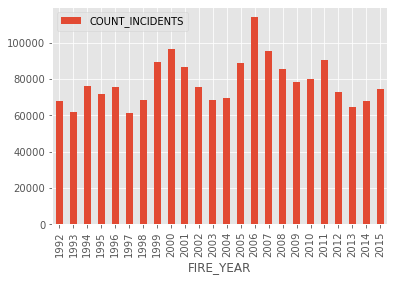

In [10]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar");

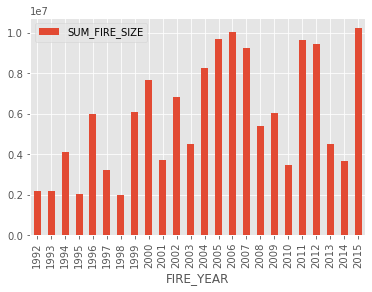

In [11]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot.bar();

In [12]:
df["SUM_FIRE_SIZE"].describe()

count    2.400000e+01
mean     5.838856e+06
std      2.832111e+06
min      2.011102e+06
25%      3.628482e+06
50%      5.705844e+06
75%      8.492013e+06
max      1.021827e+07
Name: SUM_FIRE_SIZE, dtype: float64

While the number of incidents does not draw a clear picture, the accumulated fire size does. It varies heavily and rises in general. 

## Seasonal fluctuations over year

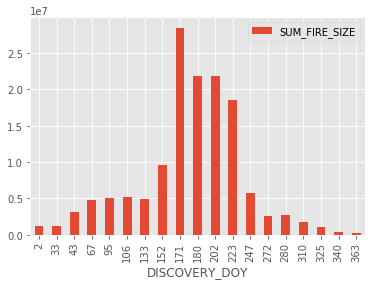

In [13]:
# Days of year (DOY) are binned trough integer division to get a lucid plot.
df = pd.read_sql_query(
    "SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/20;", 
    conn
)
df.set_index("DISCOVERY_DOY").plot.bar();

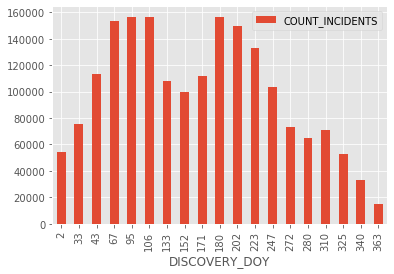

In [14]:
df = pd.read_sql_query(
    "SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/20;", 
    conn
)
df.set_index("DISCOVERY_DOY").plot(kind="bar");

The number of incidents drops unexpectedly around day 152 in an average year, while the tallest fires are discovered around day 171 or later.

## Can we predict fire size?

In [15]:
def prepare_data(conn, columns, limit=None, geohash_precision=None, apply_log=None):
    """
    Prepare the data to be ready to train. Impute values to get rid of missing values and 
    preprocess categorical values.
    
    Arguments:
        conn: SQLite connection (sqlite3) to the database.
        columns: Columns in SQL-syntax, which should be queried. Note, that you can also 
            combine columns, e. g. `(A-B) AS C`. Furthermore, a `VARCHAR`-datatype indicates 
            a categorical feature, while numbers are seen as numerical features.
        limit: Limit the amount of the queried data.
        apply_log: List of columnnames, for which a logarithm should be applied.
    Returns:
        X: Features / explanatory matrix 
        y: Response vector
    """
    
    if not "FIRE_SIZE" in columns:
        columns.append("FIRE_SIZE")
    
    columns_sql_string = ",".join(columns)
    
    limit_sql_string = ""
    if limit is not None:
        limit_sql_string = f"LIMIT {limit}"
        
    # In the current data version FIRE_SIZE is never NULL, however, since sqllite is dynamically typed, 
    # filtering does not hurt :). Same for minimum of DURATION_DAY.
    df = pd.read_sql_query(
        f"""
        SELECT {columns_sql_string} 
        FROM Fires JOIN NWCG_UnitIDActive_20170109 AS NWCG ON Fires.NWCG_REPORTING_UNIT_ID == NWCG.UnitId 
        WHERE FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0 AND DURATION_DAY > 0
        {limit_sql_string};
        """, 
        conn
    )
    
    if apply_log is not None:
        for column_name in apply_log:            
            df[column_name] = df[column_name].apply(np.log)
    
    X = df.drop(columns=["FIRE_SIZE"])
    y = df["FIRE_SIZE"]
    
    if geohash_precision is not None:
        create_geohash = lambda row: pgh.encode(row["LATITUDE"], row["LONGITUDE"], geohash_precision)
        X["GEOHASH"] = X[["LATITUDE", "LONGITUDE"]].apply(create_geohash, axis=1)
    
    # treat missing variables in numerical columns by imputing the mean
    # note, that int-typed columns can be categorical (e. g. STAT_CAUSE_CODE, but we take STAT_CAUSE_DESCR instead)
    X_numerical = X.select_dtypes(include=["float", "int"])
    fill_nan = lambda col: col.fillna(col.mean())
    X_numerical = X_numerical.apply(fill_nan)
    
    # prepare categorical columns
    X_categorical = X.select_dtypes(include=["object"])
    X_categorical = pd.get_dummies(X_categorical, dummy_na=False, drop_first=True)
    
    
    # Merge categorical and numerical
    X = pd.concat([X_numerical, X_categorical], axis=1)
    
    return X, y

X, y = prepare_data(
    conn, 
    [
        "(CONT_DATE-DISCOVERY_DATE) AS DURATION_DAY",
        """
        (
          CONT_DATE - DISCOVERY_DATE + (
            ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
          ) - (
            ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24
          )
        ) AS DURATION_COMBINED
        """, 
        """
        (
          CONT_DATE - DISCOVERY_DATE + (
            ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
          ) - (
            ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24
          )
        ) AS DURATION_COMBINED_LOG
        """, 
        """
        (
          ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24 - 
          ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
        ) AS DURATION_DAY_HOURS
        """, 
        "LATITUDE", 
        "LONGITUDE", 
        "Fires.STATE", 
        "CAST(FIRE_YEAR AS VARCHAR) AS STR_FIRE_YEAR", 
        "CAST(DISCOVERY_DOY/20 AS VARCHAR) AS STR_DISCOVERY_DOY", 
        "DISCOVERY_DATE",
        "DISCOVERY_DOY",
        "CONT_DOY",
        "(366-DISCOVERY_DOY) AS DISCOVERY_DOY_INV",
        "CAST((366-DISCOVERY_DOY)/20 AS VARCHAR) AS STR_DISCOVERY_DOY_INV",
        "CAST(STAT_CAUSE_CODE AS VARCHAR) AS STR_STAT_CAUSE_CODE", 
        "WildlandRole",
        "Department",
        "Agency",
        "GeographicArea",
        "SOURCE_SYSTEM_TYPE",
        "SOURCE_SYSTEM",
        "Parent",
        "OWNER_CODE"
    ],
    limit=4e5,
    geohash_precision=2,
    apply_log=["FIRE_SIZE", "DURATION_COMBINED_LOG"]
)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)


# Evaluate model performance r2_score

# Predict 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Score
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

test_score, train_score

(0.41220753833435597, 0.3795868472035637)

In [17]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df.iloc[:15]

,est_int,coefs,abs_coefs
50,STATE_RI,-9.834006e+14,9.834006e+14
189,Agency_DFE,5.335900e+14,5.335900e+14
171,Department_RI,4.477564e+14,4.477564e+14
201,Agency_FFC,-2.437588e+14,2.437588e+14
154,Department_MA,2.437588e+14,2.437588e+14
170,Department_PA,-1.129858e+14,1.129858e+14
202,Agency_FFP,1.129858e+14,1.129858e+14
150,Department_IL,-8.638117e+13,8.638117e+13
162,Department_NC,-8.638117e+13,8.638117e+13
191,Agency_DFR,8.638117e+13,8.638117e+13


The fire size seems to be hard to predict, however, we are able to train a model, which can give an indicator of the size. Note, that we actually predict the logarithm of the fire size. We predict rather the order of magnitude of the fire size, not the raw fire size. Presumably the order of magnitude has a characteristic, which is closer to a linear one, than the actual fire size.

In [18]:
# cleanup; close connections
conn.close()